In [1]:
import numpy as np
import os
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

import copy

from prob2utils_YM import train_model, get_err

%matplotlib inline

ratings = pd.read_csv(os.path.join('data', 'data.txt'), sep='\t', header=None, names=['User ID', 'Movie ID', 'Rating'])

# Read in information on movies
names = ['Movie ID', 'Movie Title', 'Unknown', 'Action',
         'Adventure', 'Animation', 'Children\'s', 'Comedy',
         'Crime', 'Documentary', 'Drama', 'Fantasy',
         'Film-Noir', 'Horror', 'Musical', 'Mystery',
         'Romance', 'Sci-Fi', 'Thriller', 'War', 'Western']
movies = pd.read_csv(os.path.join('data', 'movies.txt'), sep='\t', header=None, encoding='latin_1', names=names)
movies['Movie Title'] = movies['Movie Title'].str.strip()

savefig_kwargs = {'dpi': 200, 'bbox_inches': 'tight', 'transparent': True}
plt.rc('pdf', fonttype=42)
#%config InlineBackend.figure_format = 'pdf'
%config InlineBackend.print_figure_kwargs = savefig_kwargs

In [2]:
# Separate movie name and year if desired
split_year = False
if split_year:
    movies.loc[266, 'Movie Title'] = 'unknown (0000)'
    movies.loc[1411, 'Movie Title'] = \
        'Land Before Time III: The Time of the Great Giving (V) (1995)'
    movies['Year'] = [int(title[-5:-1]) for title in movies['Movie Title']]
    movies['Movie Title'] = [title[:-7] for title in movies['Movie Title']]

In [3]:
# Merge ratings data with movie metadata
pdData = ratings.merge(movies, how='left', on='Movie ID')
data = np.random.permutation(pdData)

In [4]:
totRate = np.zeros(len(movies))
numRate = np.zeros(len(movies))
for y in data:
    totRate[y[1] - 1] += y[2]
    numRate[y[1] - 1] += 1
    
avgRate = totRate/numRate

rMovies = copy.deepcopy(movies)
rMovies['Average Rating'] = avgRate
rMovies['Rate Number'] = numRate

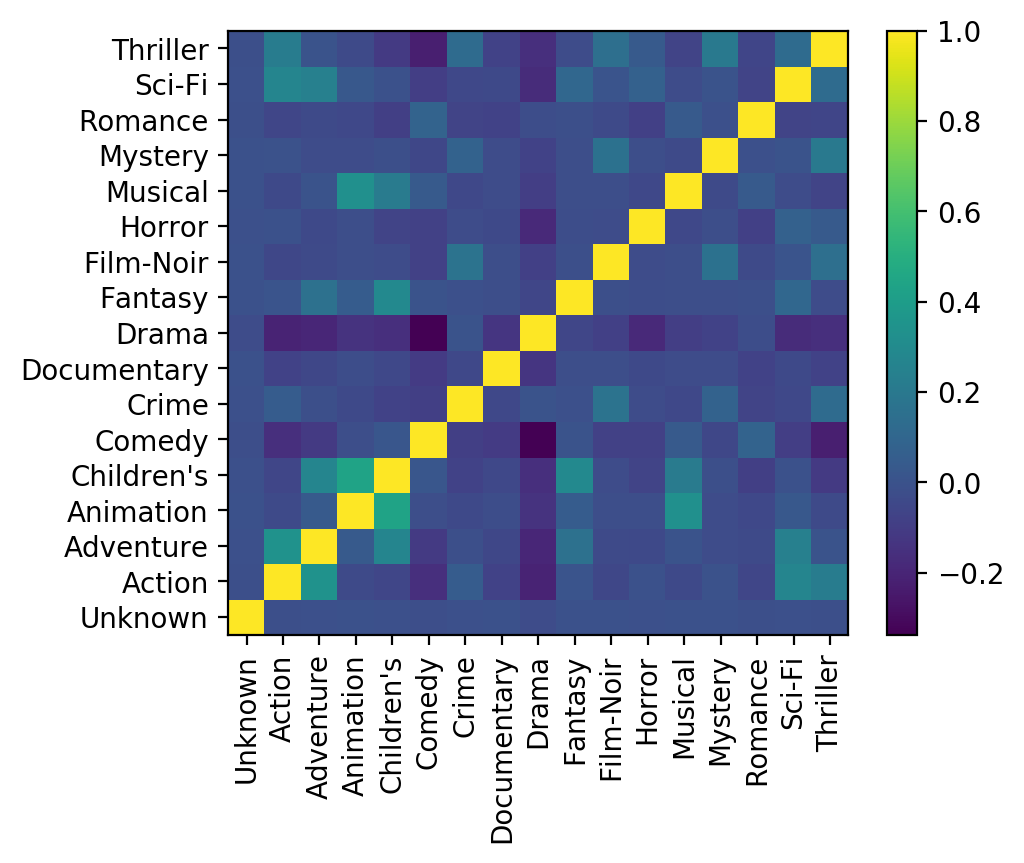

In [5]:
genreCorr = np.corrcoef(np.array(movies.iloc[:, 2:-2]).T)
fig, ax = plt.subplots(1, 1, figsize=(5, 4))
heatmap = ax.pcolor(genreCorr)
ax.set_yticks(np.arange(genreCorr.shape[0]) + 0.5, minor=False)
ax.set_xticks(np.arange(genreCorr.shape[1]) + 0.5, minor=False)

ax.set_xticklabels(movies.columns[2:-2], minor=False, rotation=90)
ax.set_yticklabels(movies.columns[2:-2], minor=False)

fig.colorbar(heatmap)

plt.show()

In [6]:
trainData = data[0: 90000]
testData = data[90000:]

In [7]:
M = max(max(trainData[:,0]), max(testData[:,0])) # users
N = max(max(trainData[:,1]), max(testData[:,1])) # movies
print("Factorizing with ", M, " users, ", N, " movies.")


Factorizing with  943  users,  1682  movies.


In [8]:
K = 20
U, V, loss = train_model(M, N, K, 0.03, 0.32, trainData[:, 0:3], eps=1e-10, max_epochs=300)
print('Testing error is: {0:.2f}'.format(get_err(U, V, testData[:, 0:3])))

early stop at 2
Testing error is: 1.05


In [9]:
u, s, vh = np.linalg.svd(V)
rotV = V @ vh.T
print(s/np.sum(s))

[0.34663486 0.0383332  0.0382538  0.03728168 0.03710773 0.03628641
 0.03601962 0.03547317 0.03539164 0.03535607 0.03470302 0.03430065
 0.03363244 0.03318381 0.0325547  0.03206274 0.0319074  0.03120048
 0.03072438 0.02959218]


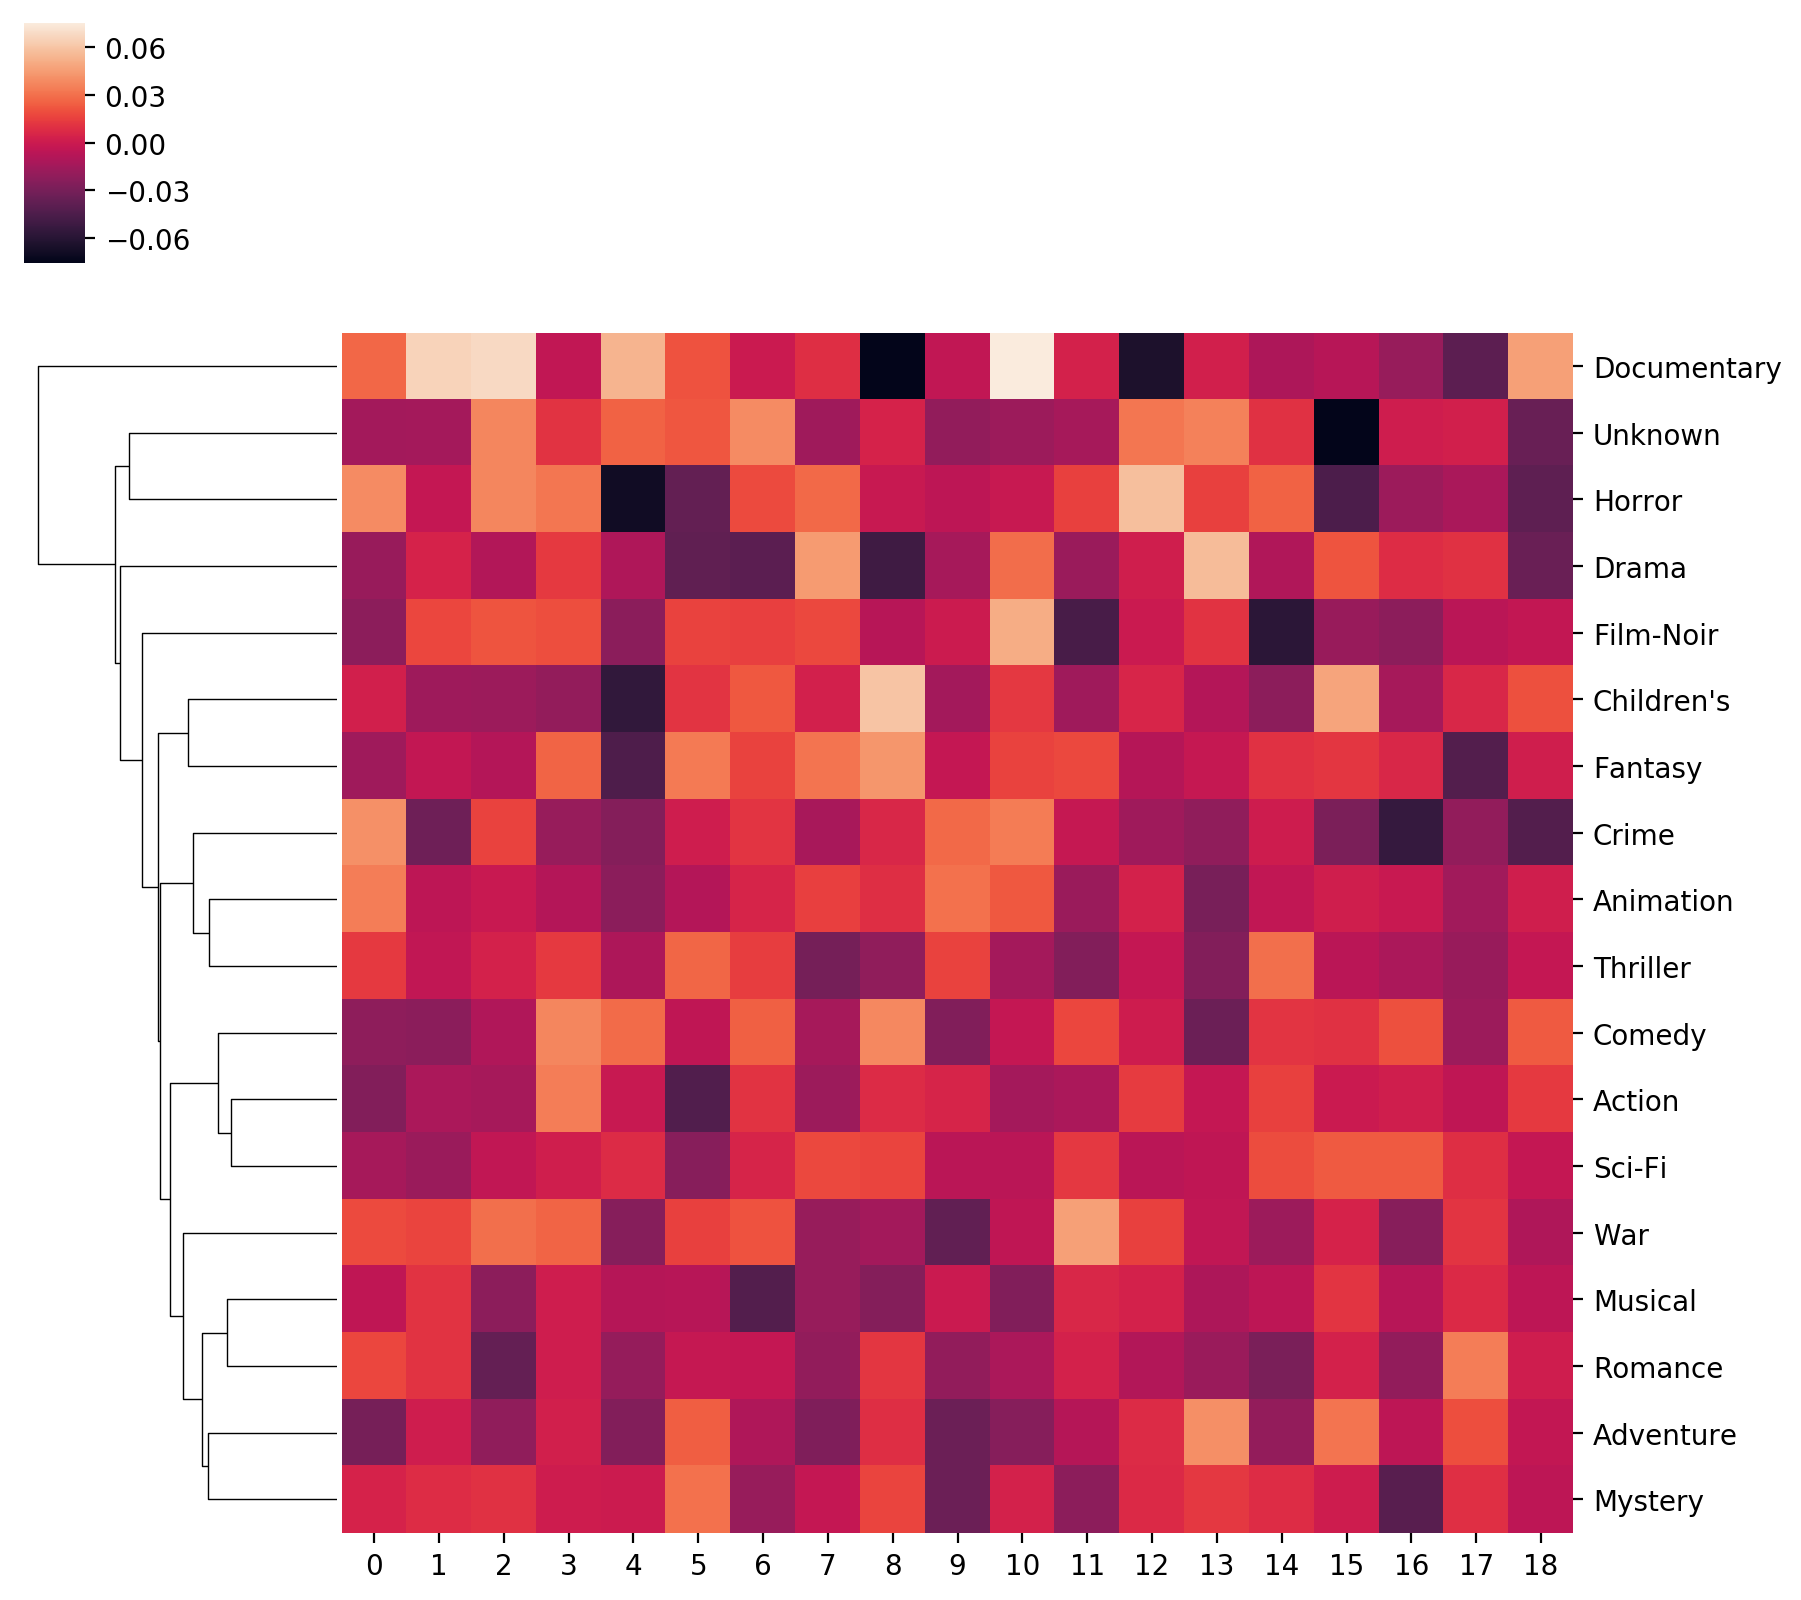

In [10]:
genres = movies.columns[2:-1]
coefs = np.zeros((len(genres), rotV[:, 1:].shape[1]))

for i in range(len(genres)):
    for j in range(rotV[:, 1:].shape[1]):
        coef = np.corrcoef(np.array(movies.iloc[:, i + 2]), rotV[:, j + 1])[0, 1]
        coefs[i, j] = coef

pdCoefs = pd.DataFrame(coefs, index=genres)
sns.clustermap(pdCoefs, col_cluster=False, method='average')

Text(0.5, 68.99999999999991, 'Factor #')

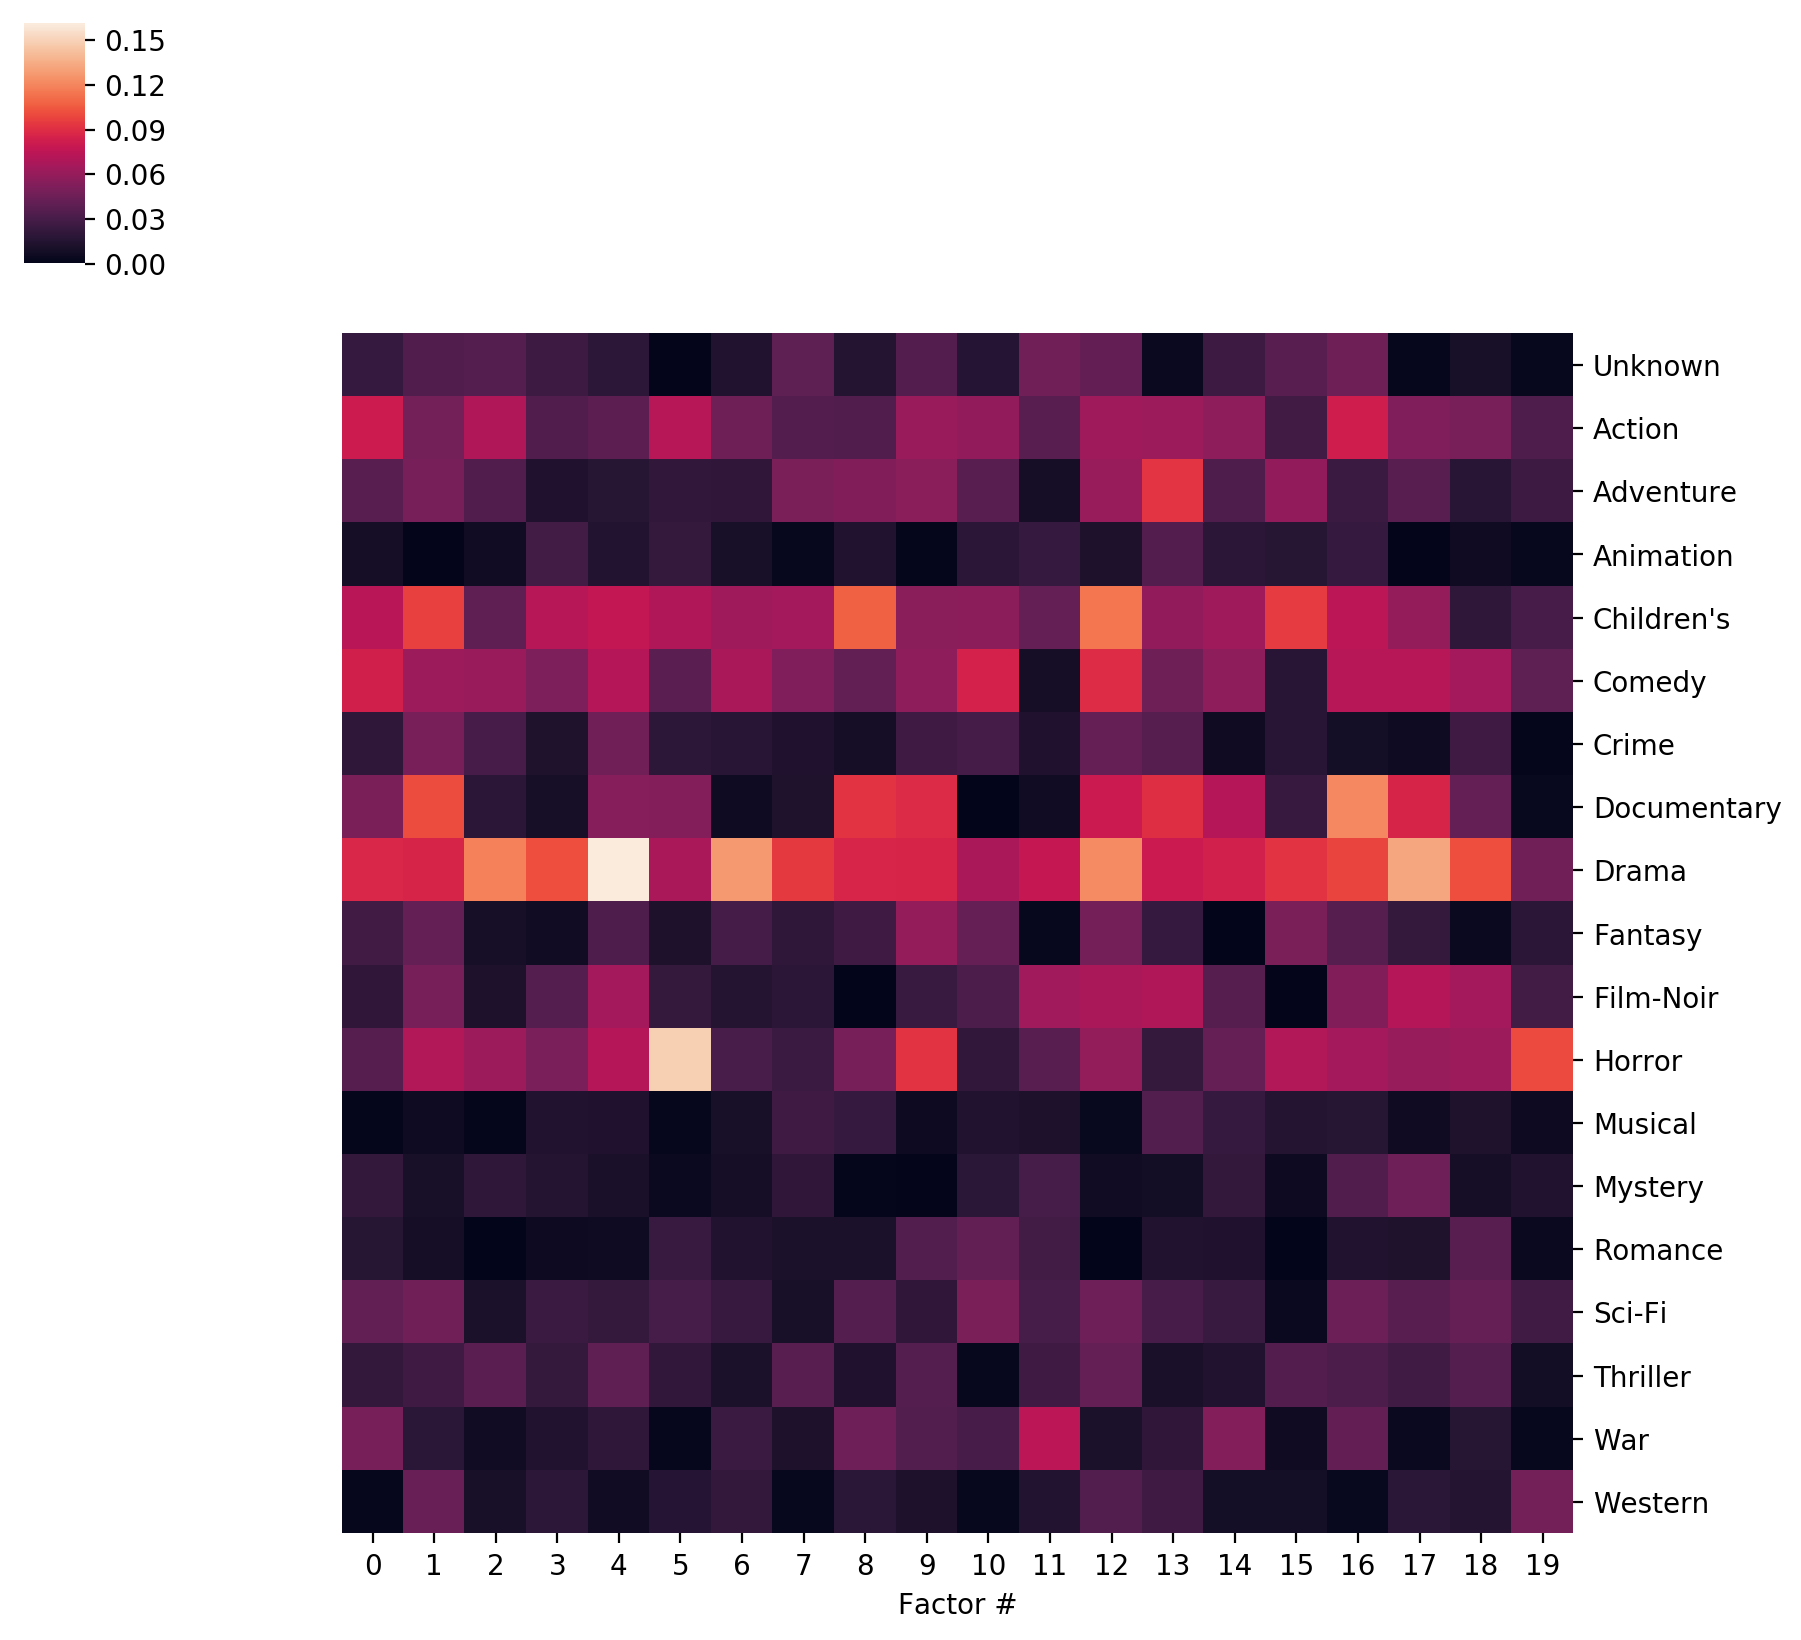

In [11]:
genres = movies.columns[2:]
coefs = np.zeros((len(genres), V.shape[1]))

for i in range(len(genres)):
    for j in range( V.shape[1]):
        coef = np.corrcoef(np.array(movies.iloc[:, i + 2]), V[:, j])[0, 1]
        coefs[i, j] = coef

pdCoefs = pd.DataFrame(np.abs(coefs), index=genres)
cm = sns.clustermap(pdCoefs, col_cluster=False, row_cluster=False, method='average')
cm.ax_heatmap.set_xlabel('Factor #')

Text(0, 0.5, 'Movie average rating')

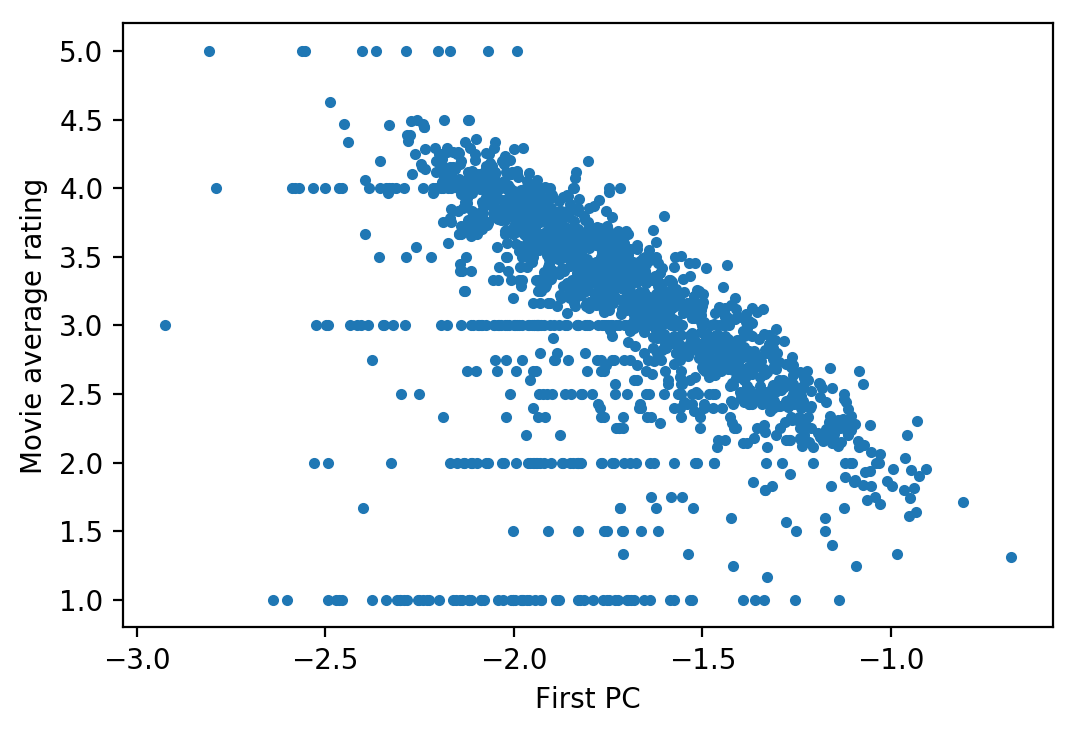

In [13]:
plt.plot(rotV[:,0], rMovies['Average Rating'], '.')
plt.xlabel('First PC')
plt.ylabel('Movie average rating')

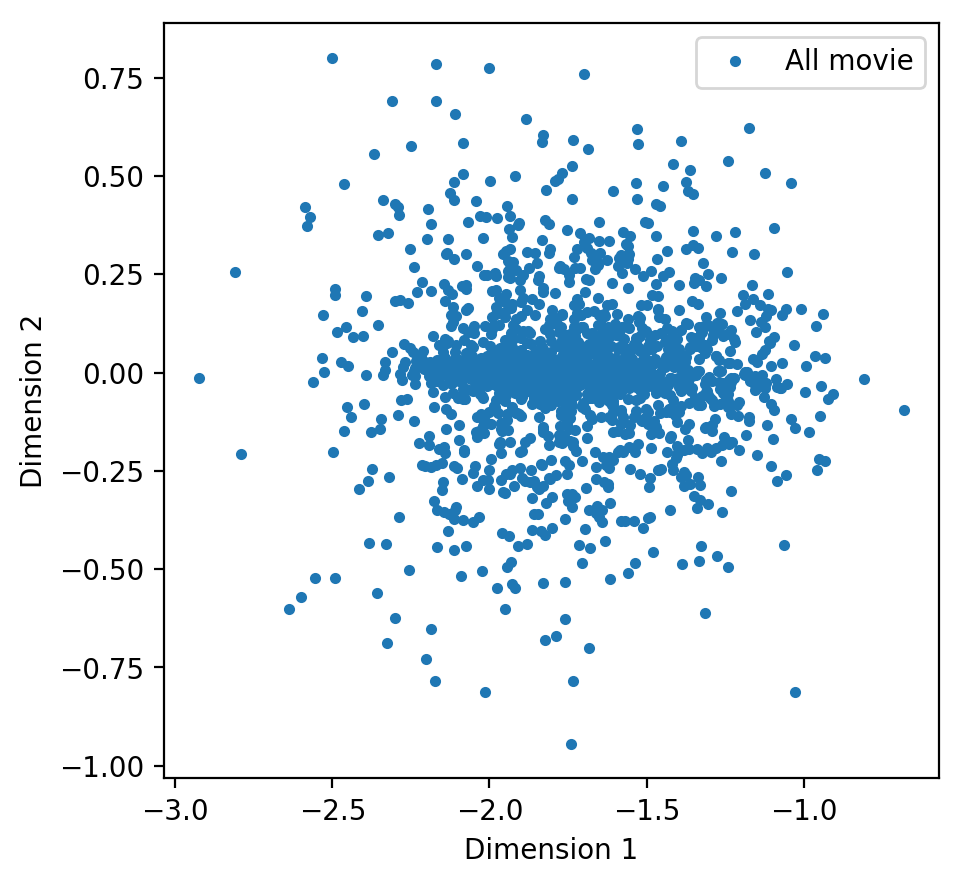

In [40]:
plt.figure(figsize=(5, 5))
plt.plot(rotV[:, 0], rotV[:, 1], '.', label='All movie')
plt.xlabel('Dimension 1')
plt.ylabel('Dimension 2')
plt.legend()

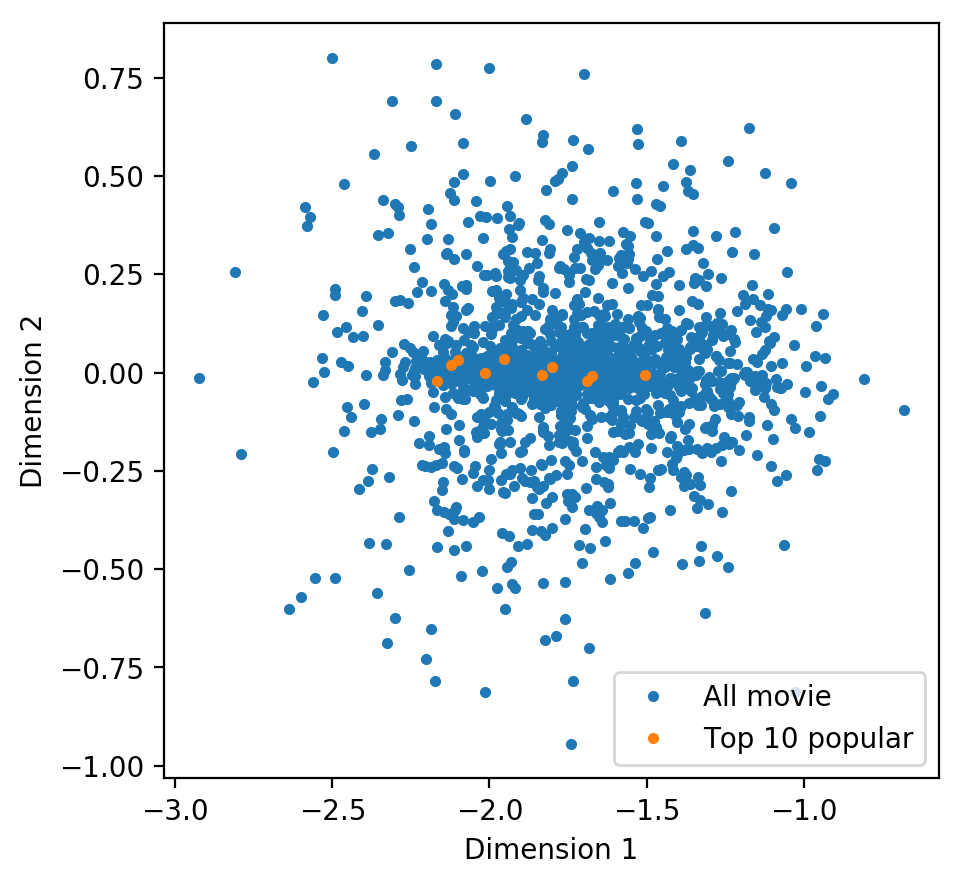

In [48]:
mMovies = copy.deepcopy(rMovies)
sortMovies = mMovies.sort_values(ascending = False, by=['Rate Number'])
topRateN = sortMovies.head(10)

popIndex = np.array(topRateN['Movie ID']) - 1

plt.figure(figsize=(5, 5))
plt.plot(rotV[:, 0], rotV[:, 1], '.', label='All movie')
plt.plot(rotV[popIndex, 0], rotV[popIndex, 1], '.', label='Top 10 popular')
plt.xlabel('Dimension 1')
plt.ylabel('Dimension 2')
plt.legend()

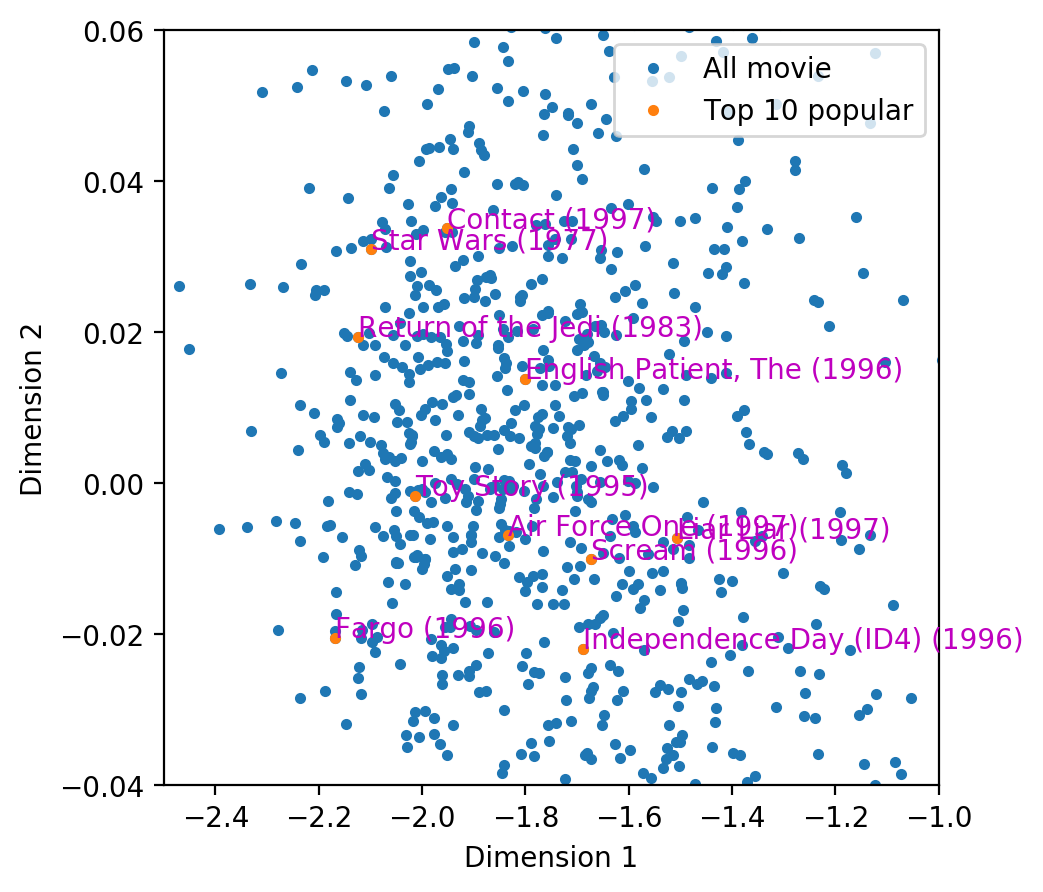

In [67]:
mMovies = copy.deepcopy(rMovies)
sortMovies = mMovies.sort_values(ascending = False, by=['Rate Number'])
topRateN = sortMovies.head(10)

popIndex = np.array(topRateN['Movie ID']) - 1

plt.figure(figsize=(5, 5))
plt.plot(rotV[:, 0], rotV[:, 1], '.', label='All movie')
plt.plot(rotV[popIndex, 0], rotV[popIndex, 1], '.', label='Top 10 popular')
plt.xlabel('Dimension 1')
plt.ylabel('Dimension 2')
plt.xlim(-2.5, -1)
plt.ylim(-0.04, 0.06)

for rec in popIndex:
    plt.text(rotV[rec, 0], rotV[rec, 1], topRateN.loc[rec]['Movie Title'], color='m')

plt.legend()

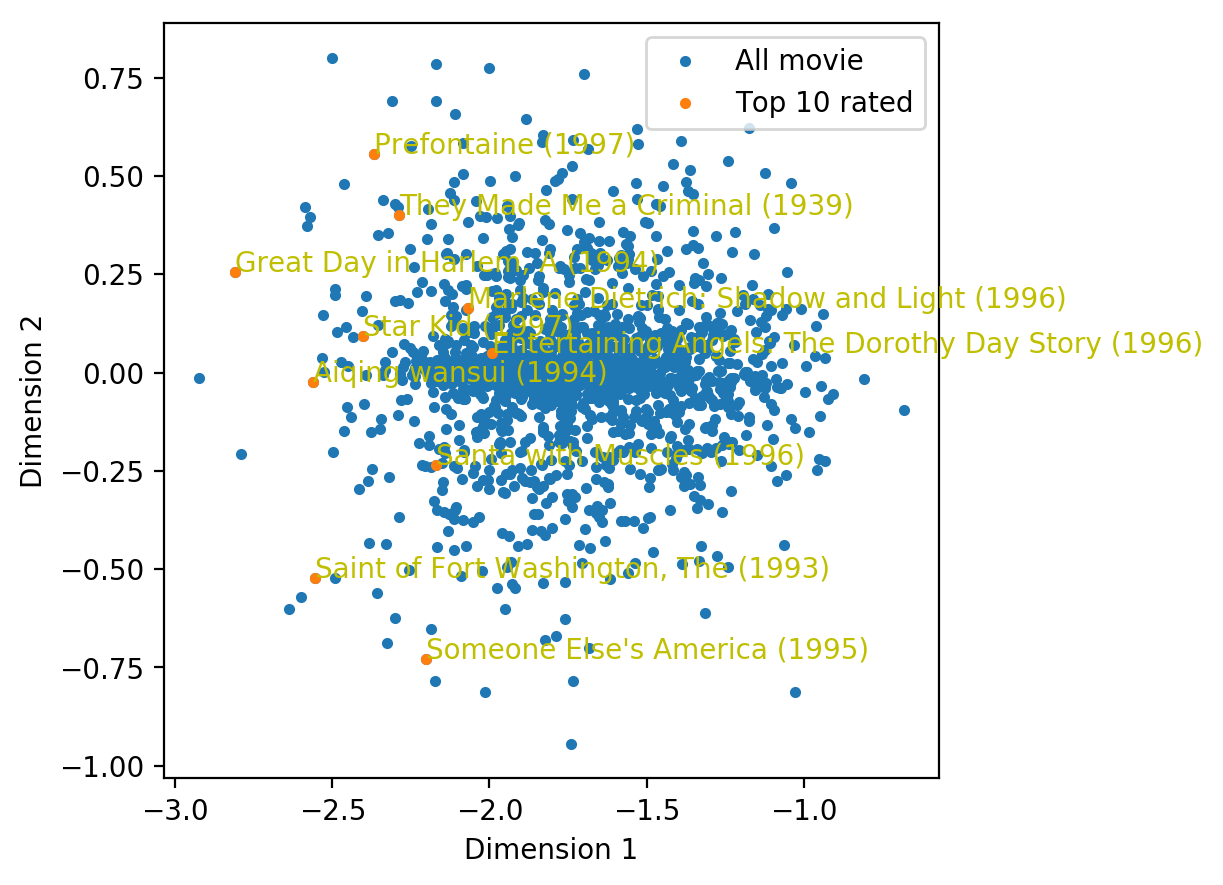

In [69]:
mMovies = copy.deepcopy(rMovies)
sortMovies = mMovies.sort_values(ascending = False, by=['Average Rating'])
topRated = sortMovies.head(10)

rateIndex = np.array(topRated['Movie ID']) - 1

plt.figure(figsize=(5, 5))
plt.plot(rotV[:, 0], rotV[:, 1], '.', label='All movie')
plt.plot(rotV[rateIndex, 0], rotV[rateIndex, 1], '.', label='Top 10 rated')
plt.xlabel('Dimension 1')
plt.ylabel('Dimension 2')

for rec in rateIndex:
    plt.text(rotV[rec, 0], rotV[rec, 1], topRated.loc[rec]['Movie Title'], color='y')


plt.legend()

In [61]:
topRateN.loc[49]['Movie Title']

'Star Wars (1977)'

In [59]:
topRateN

,Movie ID,Movie Title,Unknown,Action,Adventure,Animation,Children's,Comedy,Crime,Documentary,...,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western,Average Rating,Rate Number
49,50,Star Wars (1977),0,1,1,0,0,0,0,0,...,0,0,0,1,1,0,1,0,4.358491,583.0
257,258,Contact (1997),0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,3.803536,509.0
99,100,Fargo (1996),0,0,0,0,0,0,1,0,...,0,0,0,0,0,1,0,0,4.155512,508.0
180,181,Return of the Jedi (1983),0,1,1,0,0,0,0,0,...,0,0,0,1,1,0,1,0,4.007890,507.0
293,294,Liar Liar (1997),0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,3.156701,485.0
285,286,"English Patient, The (1996)",0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,1,0,3.656965,481.0
287,288,Scream (1996),0,0,0,0,0,0,0,0,...,1,0,0,0,0,1,0,0,3.441423,478.0
0,1,Toy Story (1995),0,0,0,1,1,1,0,0,...,0,0,0,0,0,0,0,0,3.878319,452.0
299,300,Air Force One (1997),0,1,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,3.631090,431.0
120,121,Independence Day (ID4) (1996),0,1,0,0,0,0,0,0,...,0,0,0,0,1,0,1,0,3.438228,429.0
